In [89]:
import mat73
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.svm import SVC as svm
from sklearn.linear_model import LogisticRegression as lg
from sklearn.metrics import confusion_matrix,accuracy_score,balanced_accuracy_score,f1_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter,filterwarnings

import pandas as pd
import numpy as np
import scipy.io
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()):
    if "anuja" in os.environ.get('USER'):
        DATA_DIR = 'data/'
    elif 'ubuntu' in os.environ.get('USER'):
        DATA_DIR = '/home/ubuntu/Martyna/repo/AI4Health/DATAfoof/'




    

In [90]:
data = scipy.io.loadmat(DATA_DIR+'x.mat')  
df = pd.DataFrame(data['x'].reshape((data['x'].shape[0], -1)))
foof = pd.read_csv(DATA_DIR+"sensor_intercept_slope.csv")

# sparsing
df = np.array(df).reshape(data['x'].shape)
df_sparsed = np.concatenate([np.expand_dims(df[:,:,i:i+2].mean(axis = 2), axis = 2) for i in range(0, data['x'].shape[2]-2, 2)], axis = 2)
df = pd.DataFrame(df_sparsed.reshape((df_sparsed.shape[0], -1)))


# #scaling
norm = MinMaxScaler().fit(df)
df = norm.transform(df)
df = pd.DataFrame(df.reshape((df.shape[0], -1)))



columns = np.asarray([['Electrode %d - %d/2 Hz'%(i+1, j+1)] for i in range(df_sparsed.shape[1]) for j in range(df_sparsed.shape[2])])
df.columns = columns
df['IDs'] = foof['IDs']



wisc = pd.read_csv(DATA_DIR+"9994_WISC_20211209.csv")
wisc = wisc.rename(columns={"EID": "IDs"})
wisc = wisc[['IDs', 'WISC_WMI_Sum','WISC_VCI_Sum']]
wisc


,IDs,WISC_WMI_Sum,WISC_VCI_Sum
0,WISC1_001,WISC1_039,WISC1_033
1,NDARNL599TMZ,NaN,NaN
2,NDARJF045MHG,17,18
3,NDARZE542ZVH,10,21
4,NDARYH480GTD,16,20
...,...,...,...
2933,NDARJG086ZMJ,24,28
2934,NDARNC148NJ1,29,20
2935,NDARWW744VLD,NaN,NaN
2936,NDARWE582CAV,NaN,NaN


## merging tables

In [91]:
df = pd.merge(df, foof, on='IDs', how='inner')
df = pd.merge(df, wisc, on='IDs', how='inner')


#removing NaNs
df = df.dropna()
df.shape

(1627, 4308)

In [92]:
#labels_list = ['WISC_WMI_Sum']
labels_list = ['WISC_WMI_Sum','WISC_VCI_Sum']

Y = df[labels_list]
print(Y.shape)
X = df[df.columns.difference(['IDs']+labels_list)]
print(X.shape)

(1627, 2)
(1627, 4305)


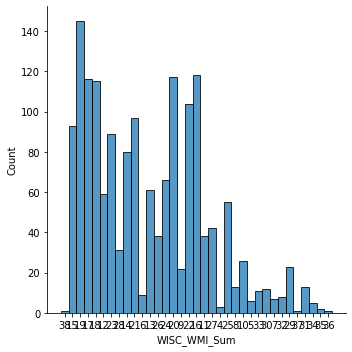

In [93]:
sns.displot(df, x='WISC_WMI_Sum', binwidth=10)


In [94]:
import numpy as np
from sklearn.preprocessing import power_transform
Y = power_transform(Y, method='box-cox')


(1627, 2)

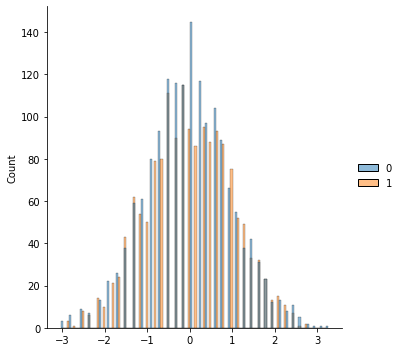

In [95]:
sns.displot(Y, binwidth=0.05)
Y.shape

## train/test division

In [96]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, shuffle=True)

In [97]:
# scaling x
norm = preprocessing.MinMaxScaler().fit(xtrain)

# transform training data
xtrain = norm.transform(xtrain)
xtest = norm.transform(xtest)
print(xtrain.shape, xtest.shape)

print('Applying PCA...')
pca = PCA(.90) # 95% variance retained
pca.fit(xtrain)

# transform data
xtrain = pca.transform(xtrain)
xtest = pca.transform(xtest)
print(xtrain.shape, xtest.shape)

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


(1220, 4305) (407, 4305)
Applying PCA...
(1220, 100) (407, 100)


In [98]:
# scaling y, in case they have different values

min_max_scaler = preprocessing.MinMaxScaler().fit(ytrain)
ytrain = min_max_scaler.transform(ytrain)
ytest = min_max_scaler.transform(ytest)

print(ytrain.shape, ytest.shape)

(1220, 2) (407, 2)


In [99]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.dummy import DummyRegressor


lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(xtrain, ytrain)
lm_dummy_median = DummyRegressor(strategy = 'median').fit(xtrain, ytrain)
ypred_dummy_mean = lm_dummy_mean.predict(xtest)
ypred_dummy_median = lm_dummy_median.predict(xtest)


print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(ytest,
																	ypred_dummy_mean)))

print("Median absolute error (dummy): {:.2f}".format(median_absolute_error(ytest,
																	ypred_dummy_median)))

print("r2_score (dummy mean): {:.2f}".format(r2_score(ytest, ypred_dummy_mean)))
print("r2_score (dummy median): {:.2f}".format(r2_score(ytest, ypred_dummy_median)))

print(ytest[:10])
print(Y.mean())

Mean squared error (dummy): 0.03
Median absolute error (dummy): 0.10
r2_score (dummy mean): -0.00
r2_score (dummy median): -0.00
[[0.30768774 0.53958031]
 [0.54513169 0.65576888]
 [0.48769366 0.68468743]
 [0.45854775 0.51039283]
 [0.39930516 0.45182983]
 [0.36916182 0.59778186]
 [0.71165815 0.51039283]
 [0.         0.0622873 ]
 [0.68443747 0.7135586 ]
 [0.57345644 0.42244751]]
-3.7557882775272657e-16


### MultiOutputReg

In [100]:
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create the SVR regressor
svr = SVR(epsilon=0.2)
#Create the Multioutput Regressor
mor = MultiOutputRegressor(svr)
# Train the regressor
mor = mor.fit(xtrain, ytrain)
# Generate predictions for testing data
ypred = mor.predict(xtest)


print("Mean squared error (SVC): {:.2f}".format(mean_squared_error(ytest,
																	ypred)))
print("R2 score (SVC): {:.2f}".format(mor.score(xtest, ytest)))


Mean squared error (SVC): 0.03
R2 score (SVC): -0.04


## MOR RanFor

In [101]:
from sklearn.ensemble import RandomForestRegressor


max_depth = 30
regr_multirf = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=7)
)
regr_multirf.fit(xtrain, ytrain)
y_multirf = regr_multirf.predict(xtest)


print("Mean squared error (regr_multirf): {:.2f}".format(mean_squared_error(ytest,
																	ypred)))
print("R2 score (regr_multirf): {:.2f}".format(regr_multirf.score(xtest, ytest)))

Mean squared error (regr_multirf): 0.03
R2 score (regr_multirf): 0.01


## MLP

In [103]:
in_dim = xtrain.shape[1]
out_dim = ytrain.shape[1]


model = Sequential()
model.add(Dense(8, activation="relu"))
model.add(Dense(4, activation="relu"))
model.add(Dense(2, activation="relu"))

model.add(Dense(out_dim))
model.compile(loss="mse", metrics = ['mse'], optimizer="adam")


model.fit(xtrain, ytrain, epochs=100, batch_size=2, validation_split = 0.2, verbose=1)
ypred = model.predict(xtest)

score = tf.keras.metrics.mean_squared_error(
    ytest, ypred
)
score= np.array(score)
score.mean()

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

488/488 [==============================] - 1s 2ms/step - loss: 0.1012 - mse: 0.1012 - val_loss: 0.0458 - val_mse: 0.0458
Epoch 2/100
488/488 [==============================] - 1s 1ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 3/100
488/488 [==============================] - 1s 1ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 4/100
488/488 [==============================] - 1s 1ms/step - loss: 0.0275 - mse: 0.0275 - val_loss: 0

0.044209275